# PIC 16B Project: Brain Tumor Classification

In our course project, we explore the relationship between neuroscience and computer vision to create a machine learning pipeline that is able to classify magnetic resonance imaging (MRI) as either healthy or tumourous. In our framework, we go on to classify tumourous cells as either meningioma, glioma, or pituitary tumors. Before we begin, we provide some biological differences between the tumor types as relavant in the clinical setting. 
<br/><br>

A **brain tumor** is a cancerous or noncancerous mass or growth of abnormal cells in the brain. 
<br/><br>

**Meningioma tumors** originate in the meninges, which are the outer three layers of tissue between the skull and the brain that cover and protect the brain just under the skull. Meningioma tumors are typically benign.  
<br/><br>

**Glioma tumors** are found in the cerebrum (the large, outer part of the brain), but also in the cerebellum (located at the base of the brain). Gliomas are the most prevalent type of adult brain tumor and are considered to be malignant, meaning they often grow quickly and can metastasize. Under the broader definition of glioma tumors, there are subtypes of glial tumors, including astrocytomas, ependymomas, glioblastomas multiforme (GBM), medulloblastomas, and oligodendrogliomas. 
<br/><br>

**Pituitary tumors** are an abnormal growth of cells in the pituitary gland, which is the main hormone-producing gland in the body and is located in the center of the brain behind the nose and eyes. Like meningioma tumors, a large portion of pitutirary tumors are considered benign and are slow-growing. 
<br/><br>


-----

“Brain Tumors.” AANS, www.aans.org/en/Patients Neurosurgical-Conditions-and-Treatments/Brain-Tumors. 

-----

Before we begin, we start by importing some necessary packages that will be used throughout the notebook.

In [ ]:
pip install pymatreader

In [ ]:
# importing necessary packages 
from google.colab import drive
drive.mount('/content/drive/')

import os
import numpy as np 
from pymatreader import read_mat
import pandas as pd
import tensorflow as tf
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2
import sklearn.metrics
import itertools
import random
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.linear_model import LinearRegression

import sys 
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
from brain_tumor_data_prep import get_tumor_images, get_healthy_images, get_mask_data, image_augmentation, random_sample_healthy_images, get_predictor_target_data, get_border_data, list_to_array, _3d_to_4d
from brain_tumor_plots import accuracy_plot, loss_plot, plot_confusion_matrix, plot_classified_images
from brain_tumor_position import get_border_coords, create_linear_models, plot_classified_images_with_tumor_position

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data Collection & Cleaning

We can now begin importing our data. Some background/information on the data we are using:

This brain tumor dataset contains 3064 T1-weighted contrast-enhanced images
from 233 patients with three kinds of brain tumor: meningioma (708 slices), 
glioma (1426 slices), and pituitary (930 slices). The 5-fold
cross-validation indices are also provided.

-----
This data is organized in MATLAB data format (.mat file). Each file stores a struct containing the following fields for an image:

- `cjdata.label`: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
- `cjdata.PID`: patient ID
- `cjdata.image`: image data
- `cjdata.tumorBorder`: a vector storing the coordinates of discrete points on tumor border
    - For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on the tumor border. It was generated by manually delineating the tumor border, so we can use it to generate the binary image of the tumor mask.
- `cjdata.tumorMask`: a binary image with 1s indicating tumor region

-----
This data was used in the following paper:
1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation
and Partition." PloS one 10.10 (2015).
2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector 
Representation." PloS one 11.6 (2016). Matlab source codes are available on github 
https://github.com/chengjun583/brainTumorRetrieval

-----
Jun Cheng
School of Biomedical Engineering
Southern Medical University, Guangzhou, China
Email: chengjun583@qq.com

----
We have also used another data set from Kaggle: (https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri) to collect MRI images not containing tumors (150 samples). This dataset simply contains a jpg representation for each image. 

## Loading in Brain Tumor MRI Data

In [ ]:
url = "/content/drive/MyDrive/Colab Notebooks/data/tumor_data/"
meningioma_images, meningioma_labels, meningioma_border, meningioma_mask, \
glioma_images, glioma_labels, glioma_border, glioma_mask, \
pituitary_images, pituitary_labels, pituitary_border, pituitary_mask = get_tumor_images(url)

## Loading in Healthy Brain MRI Dat

In [ ]:
url = "/content/drive/MyDrive/Colab Notebooks/data/no_tumor/"
no_tumor_images, no_tumor_labels, no_tumor_masks = get_healthy_images(url)

In the above cell, while collecting the data and putting them in their own respective lists, we have also done some minor data cleaning. 

### **Tumorous Images** 
The size of these images was originally 512 x 512, however after fitting our ML model (later on in the notebook) we found that this slowed the model significantly. As a result, we chose to reshape the image to 80 x 80 which we found as an optimal dimension that keeps the quality of the image sharp while also speeding up the model run-time significantly. 

### **Non-tumorous Images**
These images contained color (ie the RGB value was 3) so we first converted the image to grayscale in order to match the tumorous images. We then resized the image to 80 x 80 for the same reason as above.

# Machine Learning Bias and Necessary Corrections

In the code block below, we examine how many samples we have for each respective tumor class. When separating out our data into healthy vs. the three classifications of tumors, we notice that our data for each tumor type is not equal. This is something that we must account for and fix in order to reduce bias in our model. Specifically, we see that there is almost double the amount of glioma MRI images compared to meningioma MRI images. Additionally, our initial dataset does not contain many healthy brain MRI images. As a result, if we trained our model on this current dataset, biases might acrue. For example, since our current data set is comprised mostly of glioma tumors, our model may be more inclined to classify an unseen brain MRI image as a glioma. Additionally, since our model does not contain as much healthy brain MRI images, it may misclassify a non-tumourous image as a tumourous one. This would certaininly be a problem if this model was used to diagnose patients with brain cancer in the clinical setting.

Thus, to prevent bias from occuring within our model, we will aim to use 709/710 samples for each class. We will use all of the samples from the meningioma list, take a random 709 images from the glioma and pituitary lists, and use **image augmentation** to create more samples from the 150 healthy images. 

The next portion of code focuses on creating new images from already existing images:

In [ ]:
# printing the number of images for each class
print("Number of Meningioma Samples: ", len(meningioma_images))
print("Number of Glioma Samples: ", len(glioma_images))
print("Number of Pituitary Samples: ", len(pituitary_images))
print("Number of Healthy Samples: ", len(no_tumor_images))

Number of Meningioma Samples:  709
Number of Glioma Samples:  1427
Number of Pituitary Samples:  932
Number of Healthy Samples:  150


## Image Augmentation
Since we already have 150 non-tumourous images, we must create 560 more images in order to reach our goal of 709/710 images for each class. We will use a process called **data augmentation**, which is a technique that can be used to artificially expand the size of a training set by creating modified data from the existing data. We will be using the `ImageDataGenerator` function from `Keras` to achieve this task. More specifically, we will modify each of the 150 images by creating a copy that is: zoomed in/out, rotated, flipped horizontally, and brightened/darkened. Thus, for each image we will create 4 new ones. 
<br/><br>

One of the things we wanted to focus on was creating *reasonable* augmentations with regards to MRI images. For example it is not realistic for an MRI image to be taken upside down, rotated at an angle that is beyond 90 degrees, or be too bright/dark. In our code, we took this into consideration and made appropriate augmentations that are realistic.

In [ ]:
# getting augmented images
zoomed_images, rotated_images, flipped_images, bright_images = image_augmentation(no_tumor_images)

We now plot the image to give the reader a sense of what these modified images look like in comparison to the original image.

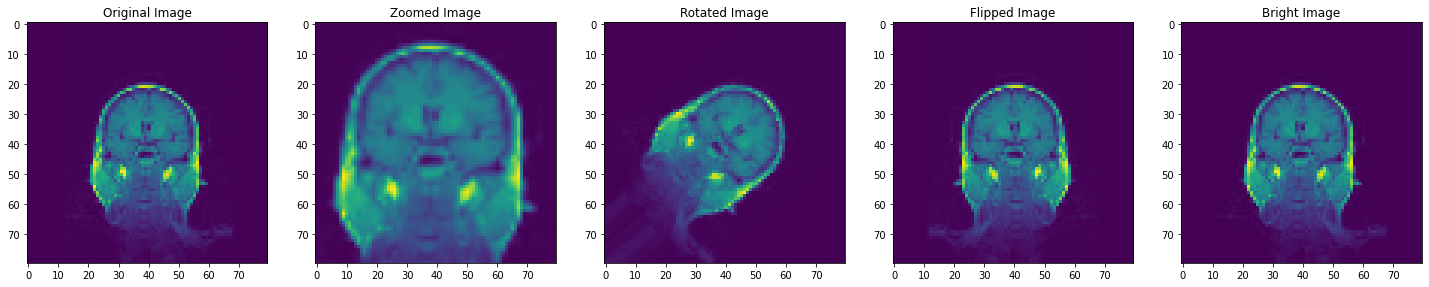

In [ ]:
# creating subplots 
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (25,25))

# plotting the original image
ax1.imshow(no_tumor_images[0])
ax1.title.set_text('Original Image')

# plotting zoomed image
ax2.imshow(zoomed_images[0])
ax2.title.set_text('Zoomed Image')

# plotting rotated image
ax3.imshow(rotated_images[0])
ax3.title.set_text('Rotated Image')

# plotting flipped image
ax4.imshow(flipped_images[0])
ax4.title.set_text('Flipped Image')

# plotting brightened image
ax5.imshow(bright_images[0])
ax5.title.set_text('Bright Image')

In each list of modified non-tumorous images, we have 150 images. In order to get to our goal of 710 non-tumorous images, we will pick a random sample of 142 images from each of the original and modified image lists and then append those to a new list which contains 710 total non-tumorous images. 

In [ ]:
# getting subset of augmented and original images 
no_tumor_images_new, no_tumor_labels = random_sample_healthy_images(no_tumor_images,zoomed_images, rotated_images, flipped_images, bright_images, 142)

In [ ]:
# checking that the number of images and labels is the same
print("Number of images in non-tumorous list: ", len(no_tumor_images_new))
print("Number of labels in non-tumorous list: ", len(no_tumor_labels))

Number of images in non-tumorous list:  710
Number of labels in non-tumorous list:  710


Now that we have dealt with the non-tumorous images, we will now take a random subset of 709 glioma/pituitary images. From there, we will create two lists which contains all of the images and all of the labels.

In [ ]:
# creating predictor and target data   
X_data, y_data = get_predictor_target_data(meningioma_images, meningioma_labels, glioma_images, glioma_labels, pituitary_images, pituitary_labels, no_tumor_images_new, no_tumor_labels)

In [ ]:
# getting border coordinates
tumor_labels, border_data = get_border_data(meningioma_labels, meningioma_border, glioma_labels, glioma_border, pituitary_labels, pituitary_border)

# Data Preprocessing
Before we get to our model, we must preprocess the data in such a way that our model is able to train from it. Recall that our images/labels are in list format. We must transform the images into a 4d array and convert the labels into an array in order for the data to be compatible with our model.

In [ ]:
# converting the lists of images and and labels into arrays
X_data_arr = list_to_array(X_data)
y_data_arr = list_to_array(y_data)

# shuffling both the images and labels
X_data_arr, y_data_arr = sklearn.utils.shuffle(X_data_arr, y_data_arr)

In [ ]:
# showing that there are the desired number of samples from each class
print("Number of Meningioma Samples: ", np.count_nonzero(y_data_arr == 1))
print("Number of Glioma Samples: ", np.count_nonzero(y_data_arr == 2))
print("Number of Pituitary Samples: ", np.count_nonzero(y_data_arr == 3))
print("Number of Non-Tumorous Samples: ", np.count_nonzero(y_data_arr == 4))

Number of Meningioma Samples:  709
Number of Glioma Samples:  709
Number of Pituitary Samples:  709
Number of Non-Tumorous Samples:  710


In [ ]:
# creating a dictionary where keys are the labels and values are the corresponding tumor type
label_encoder = {
    1: "Meningioma",
    2: "Glioma",
    3: "Pituitary",
    4: "Healthy"
}

In [ ]:
# setting seed so that we get similar results each time
np.random.seed(1234)

# getting training and testing data, save 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X_data_arr, y_data_arr, test_size = 0.3) 

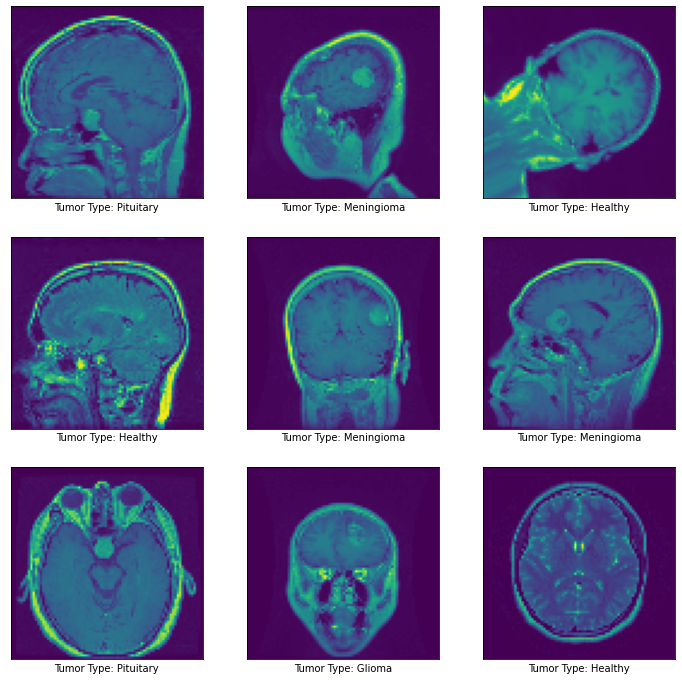

In [ ]:
# plotting some examples of MRI images and their respective tumor types
plt.figure(figsize=(12,12))
plt.title("MRI Images and Corresponding Tumors")

# plotting 9 images 
for i in range(9):
    plt.subplot(3,3,i+1)

    # adjusting format of grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # plotting images 
    plt.imshow(X_train[i].reshape(X_train[i].shape[1],X_train[i].shape[1]))

    # labeling x axis with tumor type
    plt.xlabel("Tumor Type: " + str(label_encoder.get(y_train[i])))
    
plt.show()

In [ ]:
# printing the shape of the predictor and target data 
print(f"Predictor train data shape: {X_train.shape}")
print(f"Predictor test data shape: {X_test.shape}")

print(f"\nTarget train data shape: {y_train.shape}")
print(f"Target test data shape: {y_test.shape}")


Predictor train data shape: (1985, 80, 80)
Predictor test data shape: (852, 80, 80)

Target train data shape: (1985,)
Target test data shape: (852,)


In [ ]:
# converting the train and test predictor data into 4D arrays
X_train = _3d_to_4d(X_train)
X_test = _3d_to_4d(X_test)

In [ ]:
# printing shape of predictor data which should be 4D
print(f"New predictor training data shape: {X_train.shape}")
print(f"New predictor testing data shape: {X_test.shape}")

New predictor training data shape: (1985, 80, 80, 1)
New predictor testing data shape: (852, 80, 80, 1)


# Building the Machine Learning Model
In the modeling phase of our project, we will build a convolutional neural network using `Keras`. Convolutional neural networks (CNN) are commonly used in image classification problems. Through deep learning algorithms, CNNs can take in an input image, assign importance (learnable weights and biases) to various aspects within an image and be able to differentiate one from the other.

Within our CNN, we have multiple layers, including 3 convolution layers, 3 max pooling layers, and 4 dropout layers. These layers work together in order to understand and select the important features from an image while reducing any noise from the input images.




In [ ]:
# creating the keras CNN model layer by layer
tumor_model = Sequential()
tumor_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X_train.shape[1],X_train.shape[1],1),padding='same'))
tumor_model.add(MaxPooling2D((2, 2),padding='same'))
tumor_model.add(Dropout(0.2))
tumor_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
tumor_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
tumor_model.add(Dropout(0.2))
tumor_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
tumor_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
tumor_model.add(Dropout(0.4))
tumor_model.add(Flatten())
tumor_model.add(Dense(128, activation='relu'))
tumor_model.add(Dropout(0.3))               
tumor_model.add(Dense(5, activation='softmax'))

In [ ]:
# provides a summary of the model that showcases all of the layers and the number of parameters
tumor_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       7

In [ ]:
# compiling the CNN model
tumor_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Evaluating our model

Now that we have compiled our model using the crossentropy loss between labels and predictions, we can fit our model to the training data. In the code below, we demonstrate fitting our model with 65 epochs, i.e., how many times the algorithm is going to run. Additionally, we also validate our model on unseen MRI test data. 



In [ ]:
# fitting the model
history = tumor_model.fit(X_train, 
                    y_train, 
                    epochs = 65, 
                    steps_per_epoch = 100,
                    validation_data=(X_test, y_test))

Epoch 1/65


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


100/100 [==============================] - 33s 182ms/step - loss: 86.7377 - accuracy: 0.3652 - val_loss: 1.1835 - val_accuracy: 0.6162
Epoch 2/65
100/100 [==============================] - 17s 174ms/step - loss: 1.2749 - accuracy: 0.5112 - val_loss: 1.0308 - val_accuracy: 0.6549
Epoch 3/65
100/100 [==============================] - 17s 175ms/step - loss: 1.0869 - accuracy: 0.5540 - val_loss: 0.8666 - val_accuracy: 0.7089
Epoch 4/65
100/100 [==============================] - 17s 174ms/step - loss: 0.9364 - accuracy: 0.6239 - val_loss: 0.6912 - val_accuracy: 0.7265
Epoch 5/65
100/100 [==============================] - 18s 175ms/step - loss: 0.7495 - accuracy: 0.6850 - val_loss: 0.5869 - val_accuracy: 0.7899
Epoch 6/65
100/100 [==============================] - 17s 175ms/step - loss: 0.6384 - accuracy: 0.7172 - val_loss: 0.5759 - val_accuracy: 0.7758
Epoch 7/65
100/100 [==============================] - 18s 176ms/step - loss: 0.6200 - accuracy: 0.7188 - val_loss: 0.5437 - val_accuracy: 0.

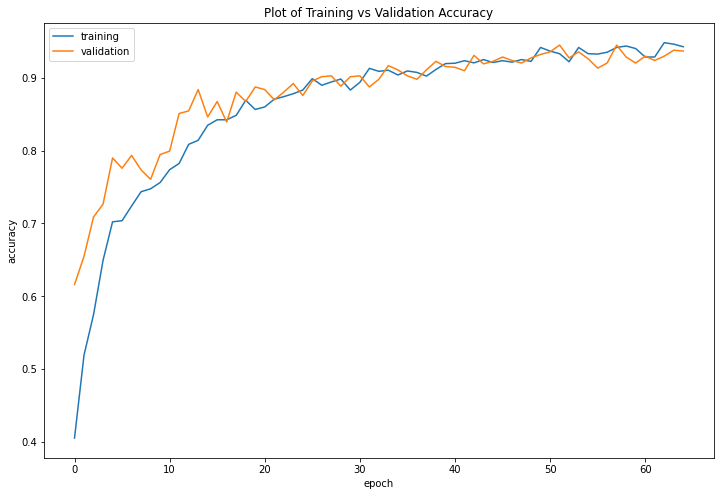

In [ ]:
# plotting accuracy graph
accuracy_graph = accuracy_plot(history)

From the plot above, we see that our model can classify a brain MRI image as healthy, meningioma, glioma, or pituitary pretty accurately. In fact, after 65 epochs, the model we built is ~94% accurate on not only training data, but also validation data. Retrieveing a high accuracy on our validation data that is also close to our training accuracy is a good sign that our model did not undergo overfitting!

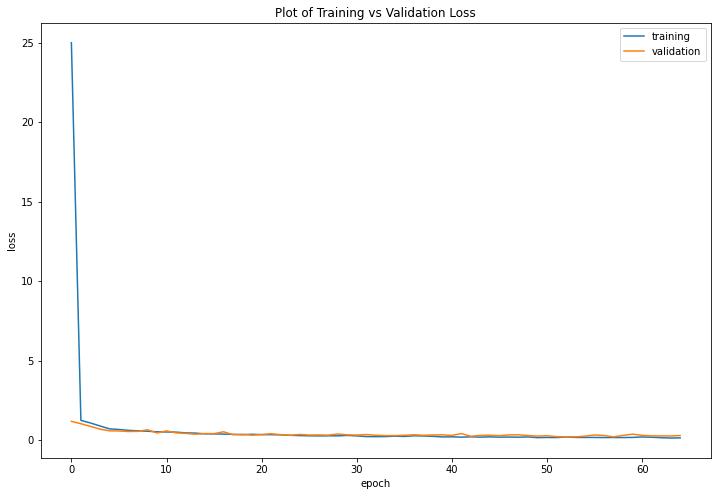

In [ ]:
# plotting loss graph
loss_graph = loss_plot(history)

In [ ]:
# getting the model predictions of the test predictor data 
y_pred = tumor_model.predict(X_test)
labels_pred = y_pred.argmax(axis = 1)

## Confusion Matrix

We can also use a confusion matrix to determine exactly where our model went wrong. A confusion matrix is often used to describe the performance of a classification model. We can use one here on our set of test MRI data in which we knnow the true labels to evaluate our model.

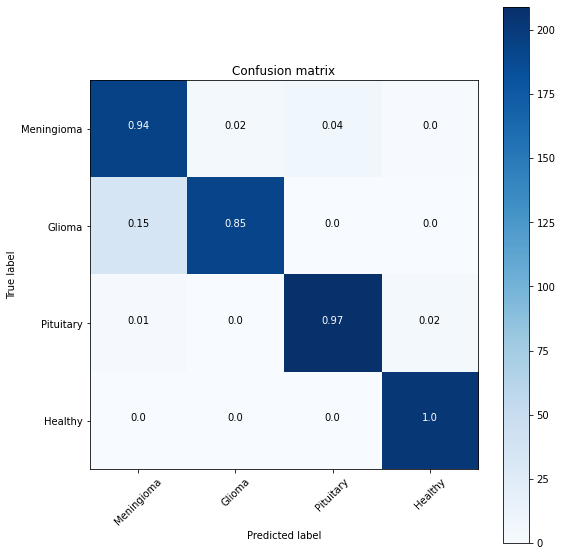

In [ ]:
# get the integer valued confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, labels_pred)

# plotting confusion matrix
figure = plot_confusion_matrix(cm, label_encoder.values())


From the confusion matrix above, we see that our model has a 100% accuracy at predicting brain MRI images that are considered healthy. It also does a great job at distinguishing meningioma (95%-98%) and pitutiary tumors (98%). Where our model doesn't do too well, however, is with glioma tumors. When given a glioma MRI image, our model only has an 84% chance of predicting it to be a glioma tumor, 16% chance of predicting it to be a meningioma tumor, and 2% chance of predicting it to be a pituitary tumor. 

We can take a look at the the images that our model classified correctly vs. the images that it misclassified in order to better understand what could have went wrong. 

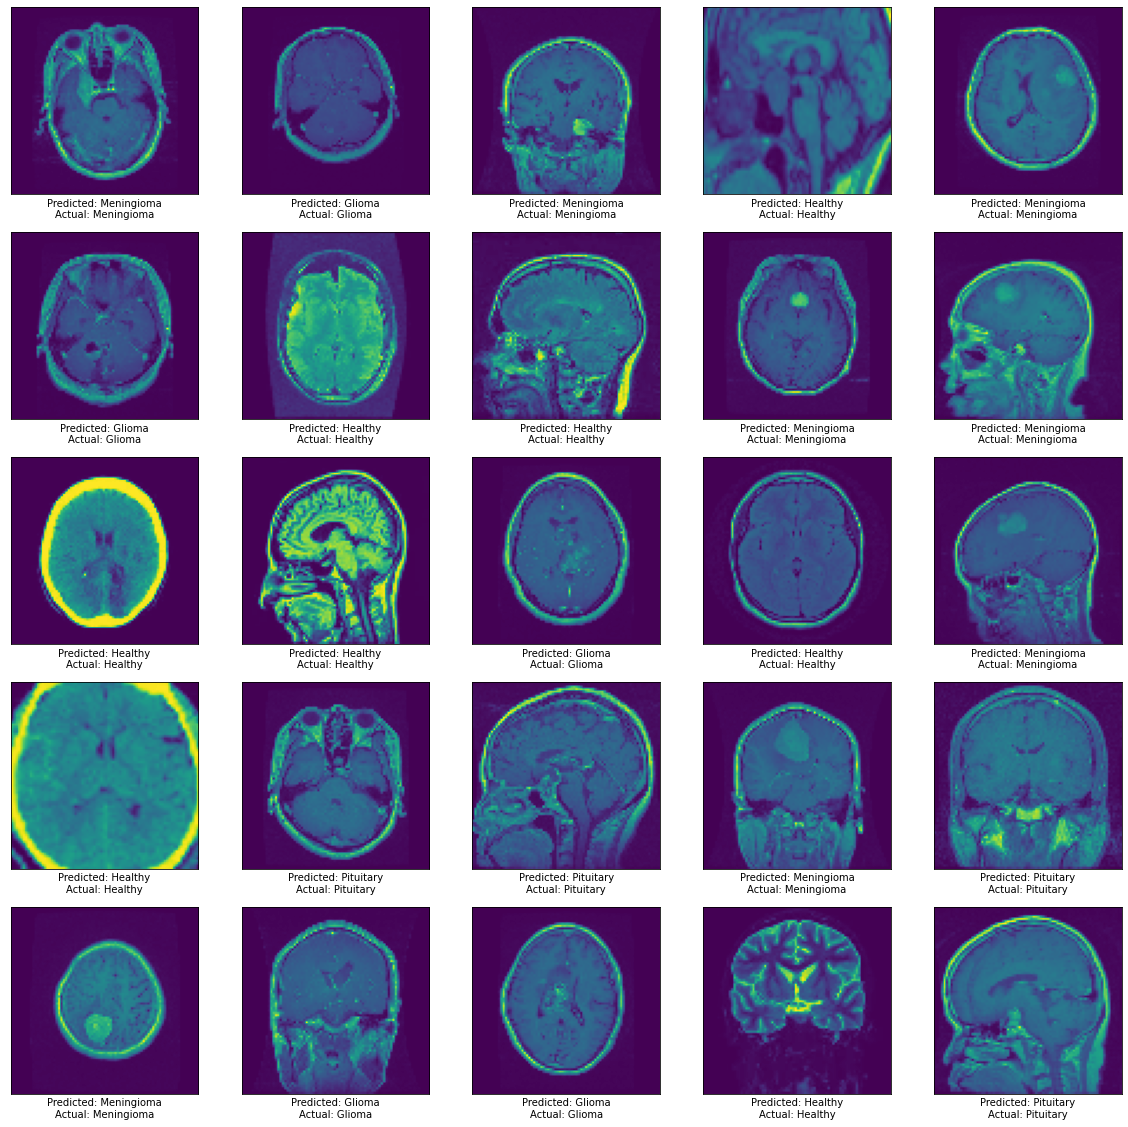

In [ ]:
# plotting correctly classified images
fig_correct = plot_classified_images(X_test, y_test,labels_pred, label_encoder, "correct")

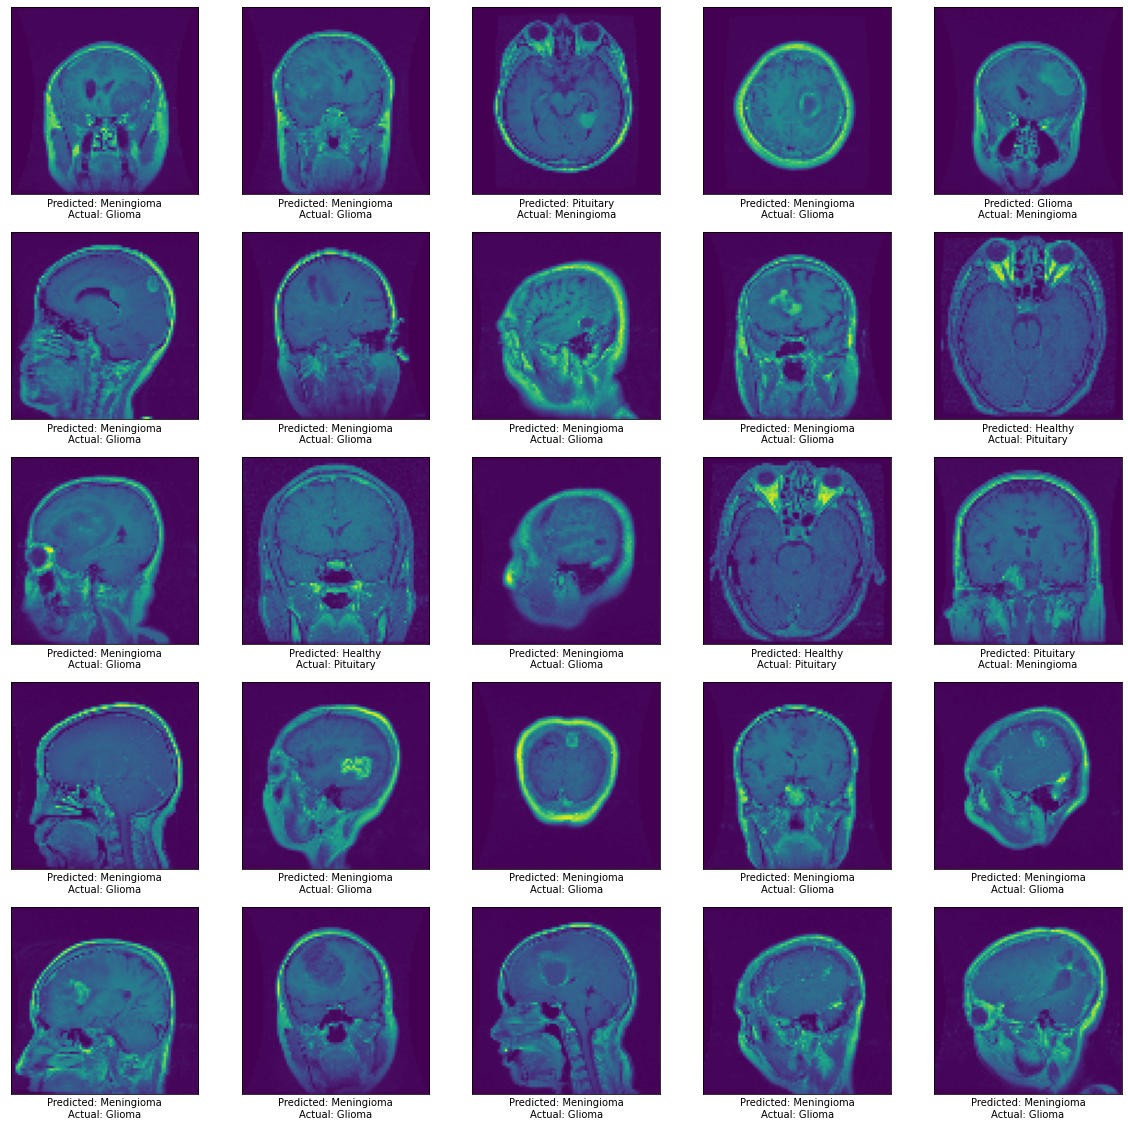

In [ ]:
# plotting incorrectly classified images
fig_incorrect = plot_classified_images(X_test, y_test,labels_pred, label_encoder, "incorrect")

From the above photos, we see that a lot of the images that are mislassified as meningioma are actually glioma tumors. It also interesting to note that, for the most part, the MRI images that are misclassfied are taken sagitally. As a reminder, gliomas are typically found in the cerebrum (the large, outer part of the brain) and in the cerebellum (located at the base of the brain). Additionally, meningiomas typically originate in the meninges, which are the outer three layers of tissue between the skull and the brain that cover and protect the brain just under the skull. In the photo below, we see the typical places that meningioma tumors can populate the brain: 
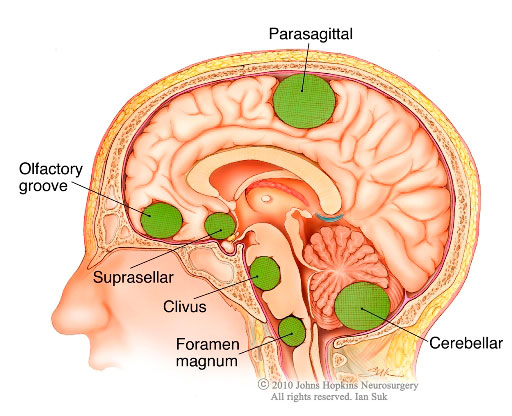

Since glioma tumors are typically found in the cerebrum, it is quite possible that the locations of a meningioma tumor may appear in the same spot as a glioma tumor from a sagittal plane. As a result, in order to improve our model, we could feed in more sagittal views of brain MRI images for gliomas and meningiomas. With this kind of data, our model could then more accurately pick up the features that differentiate a glioma from a meningioma.

# Predicting Tumor Position 
In this next section we focus on labeling the MRI images with a black dot representing the location of the classified brain tumor. If an image is healthy then we do not label that repsective image since no tumor is present. To do this, we will utilize the coordinates for the tumors that we got from the `get_border_data` function. In order to predict the location of a particular tumor, we will use a `linear regression` model with labels as the predictor data and coordinates as the target data.

The border data is structured in such a way that each tumor has a different number of coordinates `(x,y)` indicating the shape of the tumor on a coordinate grid. Thus for the following function, we will only pick data that have more than 15 coordinates denoting the tumor position.

In [ ]:
# getting x and y tumor coordinates and labels 
x,y,tumor_labels_subset = get_border_coords(border_data, tumor_labels)

# converting lists to arrays 
x = list_to_array(x)
y = list_to_array(y)
tumor_labels_subset = list_to_array(tumor_labels_subset)

# reshaping the tumor labels array so that it is the appropriate shape for the linear model
tumor_labels_subset = np.reshape(tumor_labels_subset, (-1,1))

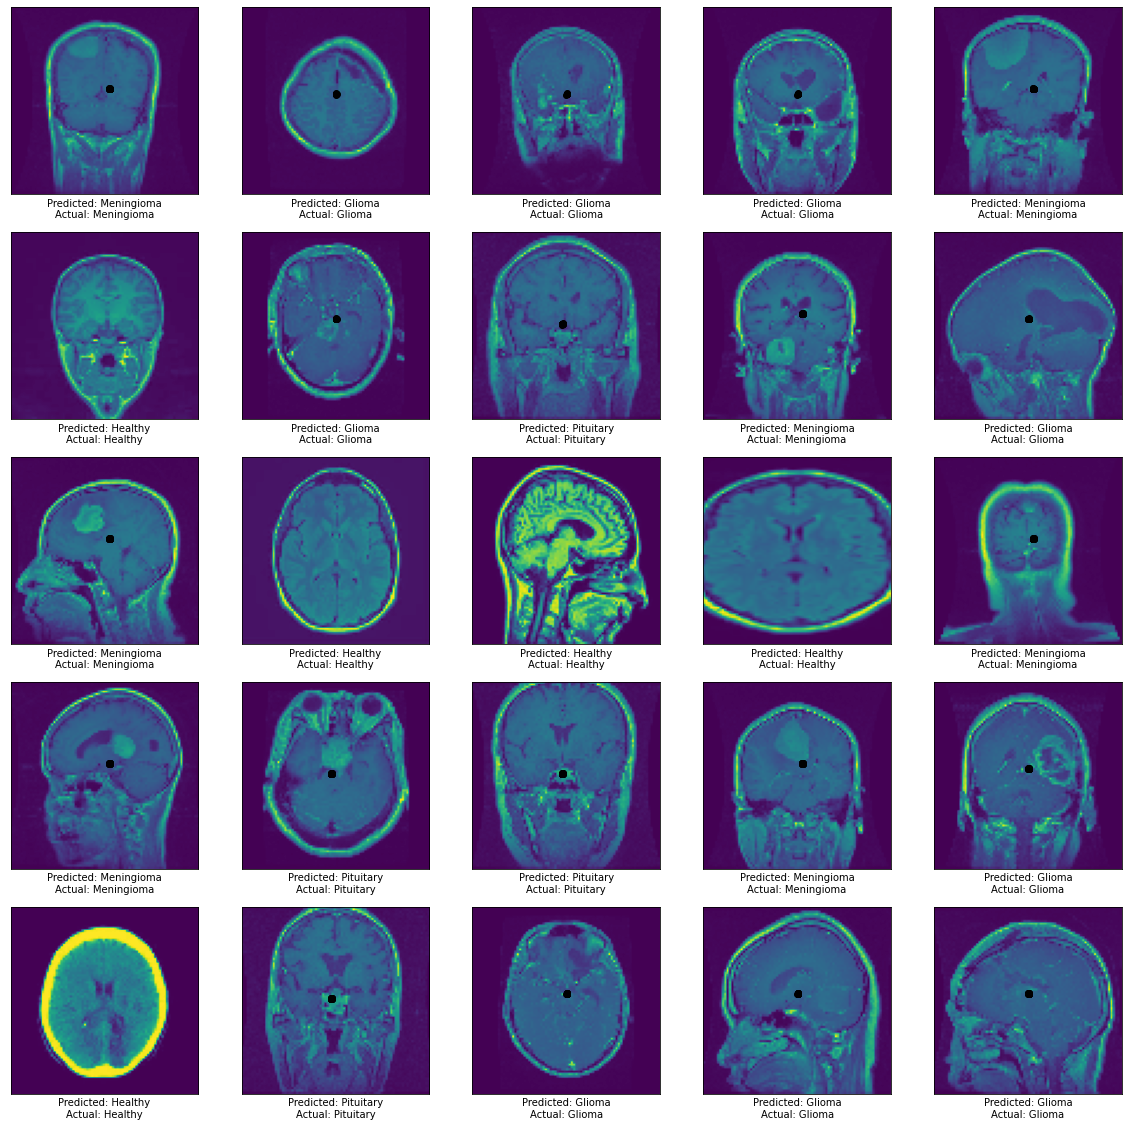

In [ ]:
# plotting correctly classified images with tumor position denoted
fig_correct_with_position = plot_classified_images_with_tumor_position(X_test, y_test,labels_pred, label_encoder, x, y, tumor_labels_subset, "correct")

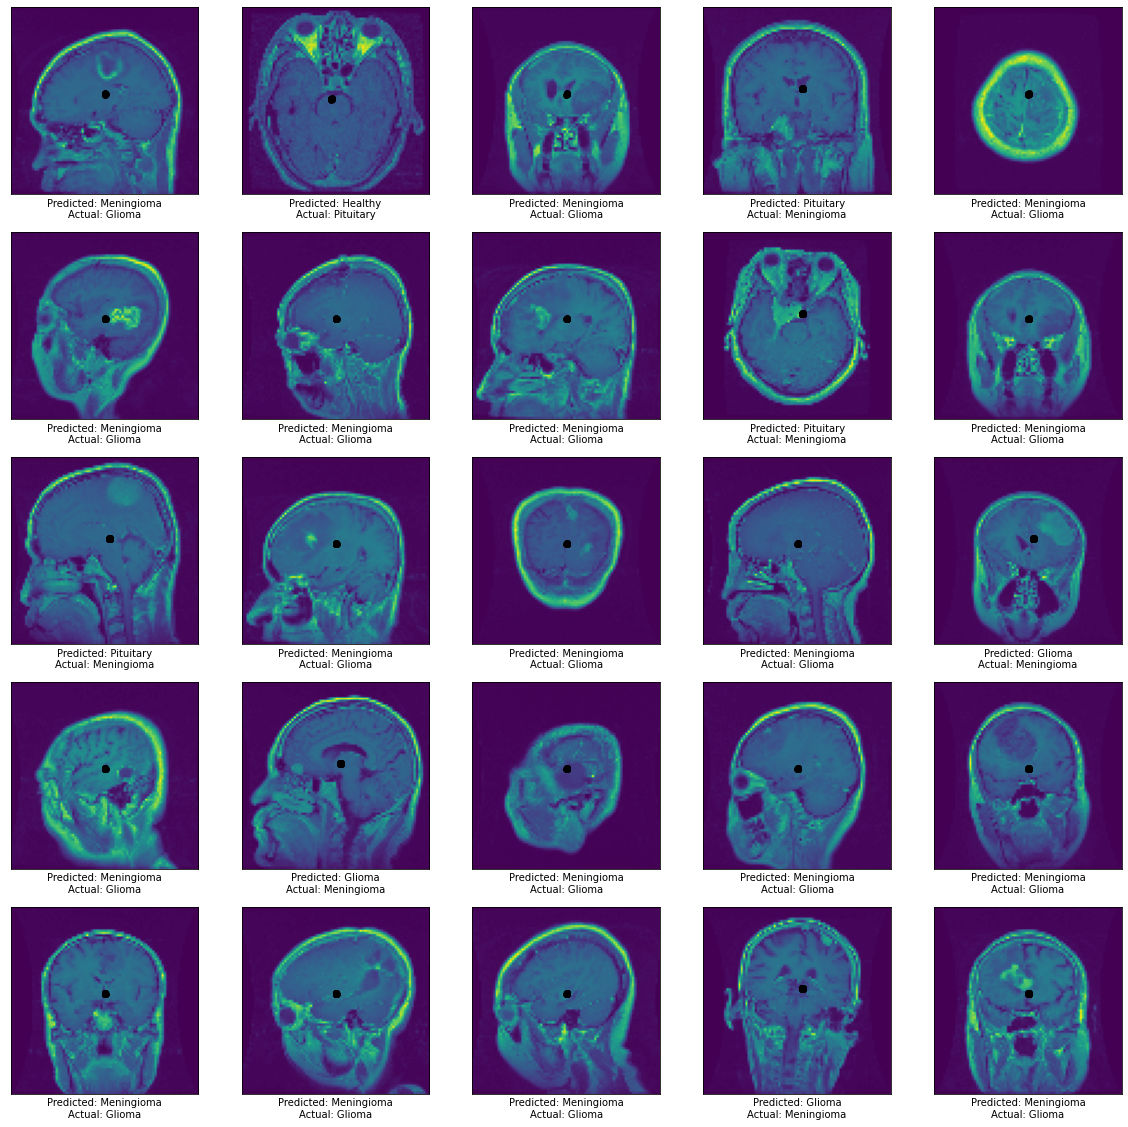

In [ ]:
# plotting incorrectly classified images with tumor position denoted
fig_incorrect_with_position = plot_classified_images_with_tumor_position(X_test, y_test,labels_pred, label_encoder, x, y, tumor_labels_subset, "incorrect")

From the plots above, we can see that linear regression does not do too well at predicting tumor positions. In some of the images where the brain lesions are very apparent, we see that our model does not predict the brain tumor positions close to where the actual brain tumor is. One reason why the linear regression model fails for this task is that linear regression is typically used in modelling the relationship between a dependent variable and one or more independent variables. In our case, the dependent variables were the x and y coordinates for the border of the brain tumor and the independent variables were the labels for the brain tumor type. Since our independent variable is not continuous and rather discrete (1, 2, 3, or 4), it is difficult for the model to produce any meaningful relationship. Thus, a more advanced model is needed to predict the brain tumor positions.

# Further Improvements: Image Segmentation

One way that our project could improve is if we we could build a model that could predict the actual regions of the brain tumor. Since the data set we downloaded does include the tumor masks, we could potentially build various deep learning models such as, fully convolutional networks, encoder-decoder based models, R-CNN based models, etc., to tackle this task. One problem that we ran into while attempting this was that the data set we downloaded did not contain actual images but rather `.mat` files. As a result, the "images" were 1 channel images, which became a problem when creating the models used for image segmentation as many of the readily available models required input images to be 3 channel images. Nevertheless, we show in the code below how we would process the data to train our model and eventually what we would want our model to predict. 

In [ ]:
X_images, y_mask_data = get_mask_data(meningioma_images, meningioma_mask, glioma_images, glioma_mask, pituitary_images, pituitary_mask, no_tumor_images_new, no_tumor_masks)

# converting the lists of images and and labels into arrays
X_data_arr_seg = list_to_array(X_images)
y_data_arr_seg = list_to_array(y_mask_data)

In the code block above, we demonstrate what we would use as our predictor variable and target data for an image segmentation model. Namely, we would want each image to be the "predictor" and the region of brain tumor (the mask) as the "target."

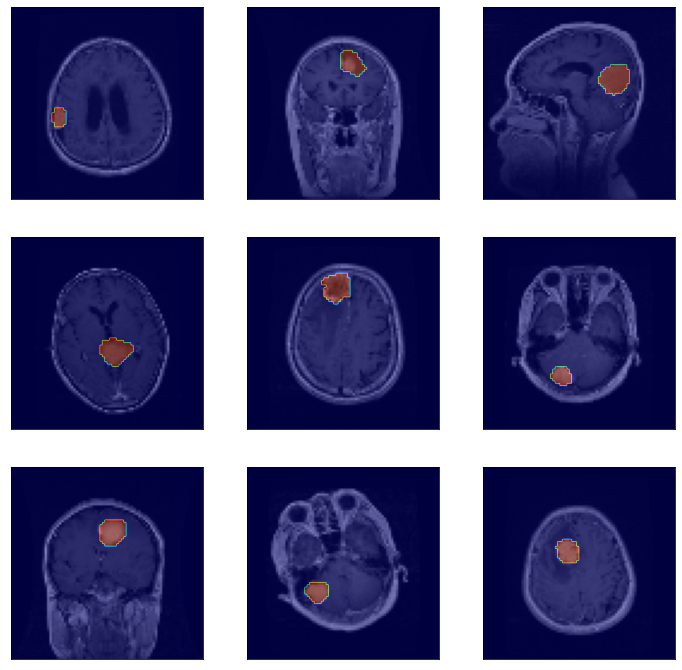

In [ ]:
# plotting some examples of MRI images and their respective tumor types
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_data_arr_seg[i], cmap = "gray")
    plt.imshow(y_data_arr_seg[i], cmap = "jet", alpha = 0.5)
plt.show()

Once the image segmentation model was built, we would want it to output images similar to the ones shown above. In these images, we see the original brain MRI image, as well as where the model believes the tumor is located. Creating a model that is able to segment the image in this way would be highly relavant in the clinical setting as neurosurgeons could use these predictions to more accurately resection a patient's brain to get rid of tumors.

# Conclusion
In this project, we have demonstrated the power of machine learning in the biological setting. We have found that just from using convolutional neural networks, we can get a pretty accurate classification of a brain tumor type from just an MRI image. According to [Johns Hopkins Medicine](https://www.hopkinsmedicine.org/neurology_neurosurgery/centers_clinics/brain_tumor/diagnosis/), diagnoses typically start with a neurological exam, followed by a brain scan (CT or MRI), and then finally a biopsy. However, biopsies are invasive procedures and come with there own set of risks and complications. In a typical setting, the MRI images will show brain lesions and a brain biopsy is often needed for an official diagnosis of brain cancer. Using machine learning, we can eliminate the step of biopsies, an invasive procedure, while still obtaining accurate diagnoses. <br>
<br>

Specifically, in our model, we obtained around 95% accuracy in terms of classifying brain tumor types as meningioma, glioma, pituitary, or healthy. However, we noticed that our model did a much better job at classifying some tumor types as opposed to others. Specifically, our convolutional neural network model does an accurate job (>= 98%) of classifying meningioma and pituitary tumors as well as healthy brain MRI images. Where our model is less accurate is distinguishing gliomas from meningiomas. As mentioned previously, when given a glioma image, our model will correctly predict it to be a glioma tumor ~84% of the time while incorrectly predicting it to be a meningioma tumor ~14% of the time. Looking further into this issue, we noticed that most of the misclassfied glioma/meningioma brain MRI images were taken from a sagittal plane. From an anatomical standpoint, the origins of these two tumors appear in the same region of the brain sagittaly, which makes its harder for our model to distinguish the two tumors if one of the features it had picked up on was brain tumor location when classifying between brain tumor types. For our model to have real world applications, we would need to be able to feed in the 3 different views of a brain MRI image as predictor variables in order to get a more accurate classification of the brain tumor type. This is what is typically done in the clinical setting for diagnosing patients with brain tumors and our model would greatly improve if it could include these other views of the brain as parameters for prediction. 
